In [1]:
# Cálcula el porcentaje de error entre dos series de máximos anuales.

import itertools
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt

import statsmodels.api        as sm
import statsmodels.stats.api  as sms

In [46]:
# Cantidad de celdas a eliminar del borde.
k = 1

# Archivos a evaluar.
eval = [ [0, 2], [0, 7], [4, 5], [5, 6], [8, 6], [9, 10], [11, 12] ]
n = 6
i = eval[n][0]
j = eval[n][1]
var = "wenzel"
#var = "medido"

name = [ "CHIRPS_interp_WRF", "CHIRPS_megalopolis", "prec_era5_hist_hist_days",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "prec_mroc_hist_hist_days", "prec_mroc_h20a_hist",
    "prec_mroc_h20a_hist_coarsen_5", "prec_mroc_2040_2040_coarsen_5",
    "WRF_regrid_CHIRPS_days_qmap", "WRF_2040_regrid_CHIRPS_days_qmap" ]

fname = name[i] + "_" + name[j]
dir = "../results/comp/" + fname + "/"

# Si no existe la carpeta, la crea.
if not os.path.exists(dir):
    os.mkdir(dir)

if var == "wenzel":
    path_orig   = "../results/" + name[i] + "/" + name[i] + "_idf_valores.nc" 
    path_comp   = "../results/" + name[j] + "/" + name[j] + "_idf_valores.nc" 
if var == "medido":
    path_orig   = "../results/" + name[i] + "/" + name[i] + "_tretorno.nc" 
    path_comp   = "../results/" + name[j] + "/" + name[j] + "_tretorno.nc" 
path_orig_s = "../results/" + name[i] + "/" + name[i] + "_stats.nc" 
path_comp_s = "../results/" + name[j] + "/" + name[j] + "_stats.nc" 

ds_orig   = xr.open_dataset(path_orig  )
ds_comp   = xr.open_dataset(path_comp  )
orig_stat = xr.open_dataset(path_orig_s)
comp_stat = xr.open_dataset(path_comp_s)

if k != 0:
    ds_orig   =   ds_orig.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    ds_comp   =   ds_comp.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )    
    orig_stat = orig_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} )
    comp_stat = comp_stat.isel(
        {"LONGITUD": slice(k, -k), "LATITUD": slice(k, -k)} ) 

vars = ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]

# Estadísticas de los valores originales.
ds_orig.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,279000.000000
mean,67.560450
std,76.431521
min,3.677272
25%,28.513487
50%,46.441778
75%,76.196613
max,1599.849417


In [48]:
ds_orig

<xarray.Dataset> Size: 2MB
Dimensions:         (LONGITUD: 62, LATITUD: 50, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 496B -100.4 -100.4 ... -97.43 -97.38
  * LATITUD         (LATITUD) float64 400B 18.17 18.22 18.27 ... 20.57 20.62
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 2MB ...

In [49]:
ds_comp

<xarray.Dataset> Size: 2MB
Dimensions:         (LONGITUD: 62, LATITUD: 50, DURACION: 9, TIEMPO_RETORNO: 10)
Coordinates:
  * LONGITUD        (LONGITUD) float64 496B -100.4 -100.4 ... -97.43 -97.38
  * LATITUD         (LATITUD) float64 400B 18.17 18.22 18.27 ... 20.57 20.62
  * DURACION        (DURACION) float64 72B 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0
  * TIEMPO_RETORNO  (TIEMPO_RETORNO) float64 80B 1.0 2.0 5.0 ... 500.0 1e+03
Data variables:
    INTENSIDAD      (LONGITUD, LATITUD, DURACION, TIEMPO_RETORNO) float64 2MB ...

In [47]:
# Error total de las estadísticas mensuales.
E = 3
est_n = ["del mínimo", "del máximo",
    "de la media", "de la desviación estándar"]
error_s = ( ( comp_stat - orig_stat ) / orig_stat
    ).rename( {"PRECIPITACION": "P_ERROR"} )
error_s.to_netcdf(dir + fname + "_stats.nc")
df_e = error_s.to_dataframe()

tot = [ error_s.sel(ESTADISTICA = E)["P_ERROR"].count(       ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].mean(        ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].std(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].min(         ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.25).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.5 ).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].quantile(0.75).values + 0,
        error_s.sel(ESTADISTICA = E)["P_ERROR"].max(         ).values + 0 ]

print(f"Errores {est_n[E - 1]} mensual entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores de la media mensual entre WRF_regrid_CHIRPS_days_qmap y WRF_2040_regrid_CHIRPS_days_qmap
count: 37200.00
mean: inf
std: nan
min: -0.69
25%: 1.77
50%: nan
75%: nan
max: inf


/opt/homebrew/Caskroom/miniforge/base/envs/xarray/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/opt/homebrew/Caskroom/miniforge/base/envs/xarray/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [26]:
# Error en el total de precipitación.
prec_e = ( comp_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum()
    / orig_stat.to_dataframe().xs(E, level = 3
    ).groupby(["LATITUD", "LONGITUD"]).sum() - 1 )

prec_e.describe()

,PRECIPITACION
count,2268.000000
mean,2.497136
std,2.082926
min,-0.098517
25%,0.969995
50%,1.744117
75%,3.600769
max,13.674657


In [51]:
# Error total.
if var == "medido":
    ds_comp = ds_comp.drop_vars( ["AÑO", "PROBABILIDAD"] )
    ds_orig = ds_orig.drop_vars( ["AÑO", "PROBABILIDAD"] )
error = ( ( ds_comp - ds_orig )
    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
#error = ( ( ds_comp.drop( ["AÑO", "PROBABILIDAD"] )
#    - ds_orig.drop( ["AÑO", "PROBABILIDAD"] ) )
#    / ds_orig ).rename( {"INTENSIDAD": "P_ERROR"} )
error.to_netcdf(dir + fname + ".nc")
df_e = error.to_dataframe()

tot = [ error["P_ERROR"].count(       ).values + 0,
        error["P_ERROR"].mean(        ).values + 0,
        error["P_ERROR"].std(         ).values + 0,
        error["P_ERROR"].min(         ).values + 0,
        error["P_ERROR"].quantile(0.25).values + 0,
        error["P_ERROR"].quantile(0.5 ).values + 0,
        error["P_ERROR"].quantile(0.75).values + 0,
        error["P_ERROR"].max(         ).values + 0 ]

print(f"Errores entre {name[i]} y {name[j]}")
for l in range( len(vars) ): print(f"{vars[l]}: {tot[l]:.2f}")

Errores entre WRF_regrid_CHIRPS_days_qmap y WRF_2040_regrid_CHIRPS_days_qmap
count: 279000.00
mean: 0.20
std: 0.92
min: -0.80
25%: -0.07
50%: 0.08
75%: 0.28
max: 101.84


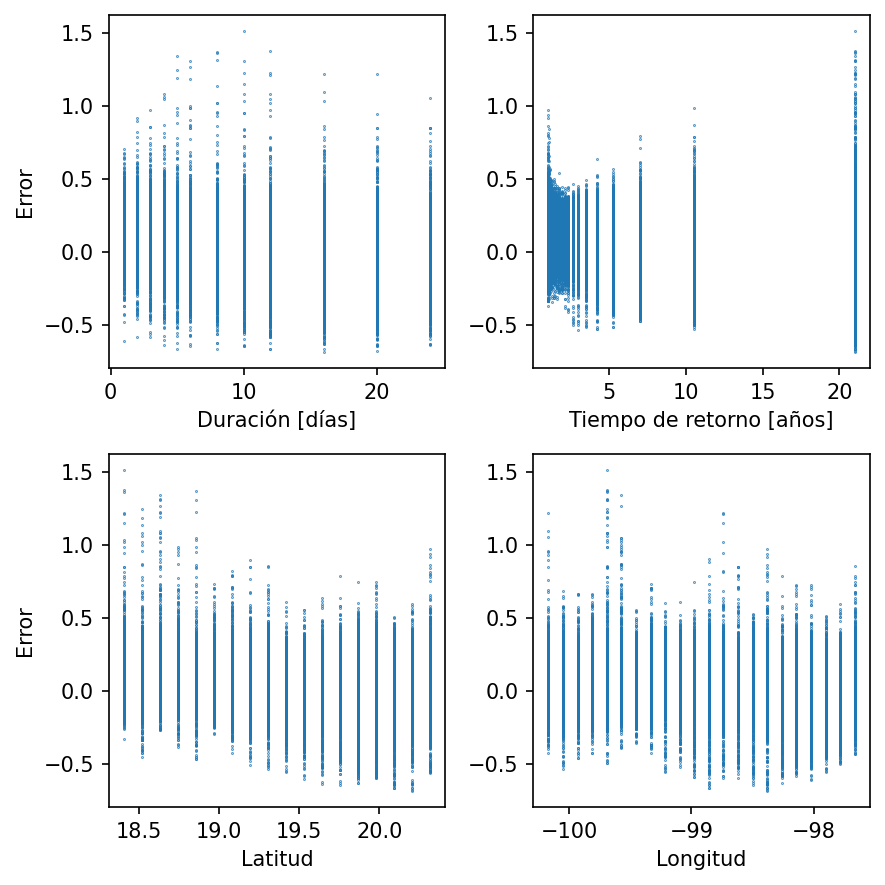

In [ ]:
# Grafica de dispersión del error.

# Incializamos gráfica.
fig, ax = plt.subplots(2, 2)
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax[0, 0].scatter( df_e.reset_index()["DURACION"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[0, 1].scatter( df_e.reset_index()["TIEMPO_RETORNO"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 0].scatter( df_e.reset_index()["LATITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )
ax[1, 1].scatter( df_e.reset_index()["LONGITUD"],
    df_e.reset_index()["P_ERROR"], s = 0.1 )

# Nombre de ejes.
ax[0, 0].set_xlabel(f"Duración [días]")
ax[0, 1].set_xlabel(f"Tiempo de retorno [años]")
ax[1, 0].set_xlabel(f"Latitud")
ax[1, 1].set_xlabel(f"Longitud")
ax[0, 0].set_ylabel("Error")
ax[1, 0].set_ylabel("Error")

fig.tight_layout()
plt.show()

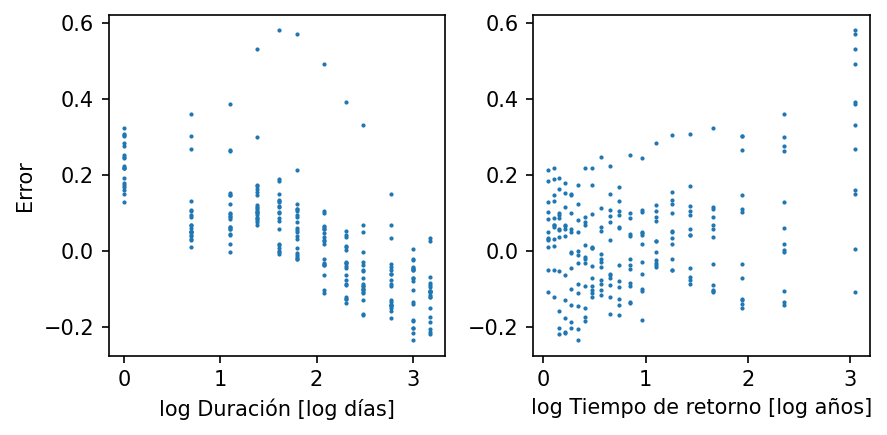

In [ ]:
# Grafica de dispersión del error para una celda en particular.

# Incializamos gráfica.
fig, ax = plt.subplots(1,2)
fig.set_facecolor("w")
fig.set_size_inches(6, 3)
fig.set_dpi(150) 

# Seleccionamos una latitud y longitud
W = 5
N = 5
lat = df_e.index.get_level_values("LATITUD").unique()[N]
lon = df_e.index.get_level_values("LONGITUD").unique()[W]
df_xs = df_e.xs( ( lat, lon ), level = ("LATITUD", "LONGITUD") )

# Graficamos.
#ax[0].scatter( f_xs.reset_index()["DURACION"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[0].scatter( np.log( df_xs.reset_index()["DURACION"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )
#ax[1].scatter( df_xs.reset_index()["TIEMPO_RETORNO"],
#    df_xs.reset_index()["P_ERROR"], s = 1 )
ax[1].scatter( np.log( df_xs.reset_index()["TIEMPO_RETORNO"] ),
    df_xs.reset_index()["P_ERROR"], s = 1 )

# Nombre de ejes.
#ax[0].set_xlabel(f"Duración [días]")
ax[0].set_xlabel(f"log Duración [log días]")
ax[0].set_ylabel("Error")
#ax[1].set_xlabel(f"Tiempo de retorno [años]")
ax[1].set_xlabel(f"log Tiempo de retorno [log años]")

fig.tight_layout()
plt.show()

In [ ]:
# Probamos variables para la regresión.

# Posibles variables.
df_reg = df_xs.reset_index()
df_reg["D_1"] = np.log(  df_reg["DURACION"] )
df_reg["D_2"] = np.sqrt( df_reg["DURACION"] )
df_reg["D_3"] = df_reg["DURACION"] ** 2
df_reg["D_4"] = df_reg["DURACION"] ** 3
df_reg["D_5"] = df_reg["DURACION"] ** 4
df_reg["D_6"] = df_reg["DURACION"] ** 5
df_reg["T_1"] = np.log(  df_reg["TIEMPO_RETORNO"] )
df_reg["T_2"] = np.sqrt( df_reg["TIEMPO_RETORNO"] )
df_reg["T_3"] = df_reg["TIEMPO_RETORNO"] ** 2
df_reg["T_4"] = df_reg["TIEMPO_RETORNO"] ** 3
df_reg["T_5"] = df_reg["TIEMPO_RETORNO"] ** 4
df_reg["T_6"] = df_reg["TIEMPO_RETORNO"] ** 5


# Predictando.
Y = df_reg["P_ERROR"]
# Predictores.
X = sm.add_constant( df_reg[ [  
                              #"DURACION",
                              #"TIEMPO_RETORNO",
                              "D_1",
                              #"D_2",
                              #"D_3",
                              #"D_4",
                              #"D_5",
                              #"D_6",
                              "T_1",
                              #"T_2",
                              #"T_3",
                              #"T_4",
                              #"T_5",
                              #"T_6",
                              ] ] )

# Regresión.
sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                P_ERROR   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     192.1
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.57e-50
Time:                        01:59:25   Log-Likelihood:                 238.41
No. Observations:                 240   AIC:                            -470.8
Df Residuals:                     237   BIC:                            -460.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1783      0.015     12.038      0.000       0.149       0.207
D_1           -0.1096      0.006    -17.348      0.000      -0.122      -0.097
T_1            0.0670      0.007      9.124      0.000       0.053       0.082
==============================================================================
Omnibus:                       56.149   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.269
Skew:                           1.077   Prob(JB):                     6.98e-30
Kurtosis:                       5.965   Cond. No.                         6.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Intentamos obtener un valor para todo el dominio.

# Error normalizado
#error_n = ( error / error.sel(DURACION = 1, TIEMPO_RETORNO = 5 )
#    ).to_dataframe().droplevel(level = (0, 1) ).reset_index()
# Error sin normalizar.
error_n = df_e.copy().reset_index()

# Regresión múltiple logarítmica.
X = sm.add_constant( np.log( error_n[["DURACION", "TIEMPO_RETORNO"]] ) )
Y = error_n[["P_ERROR"]]
model = sm.OLS(Y,X)
results = model.fit()
# Ajuste de la regresión.
results.rsquared_adj

0.0536543170262731

In [ ]:
# Hace la regresión lineal para cada celda del archivo.

# Estadísticos a guardar.
cols = [ "CONST",
        "C_LOG_DUR",
        "C_LOG_TRET",
        #"C_SQRT_DUR", "C_SQRT_TRET",
        #"C_2_DUR", "C_2_TRET",
        #"C_3_DUR", "C_3_TRET",
        #"C_DUR",
        #"C_TRET",
        "P_CONST",
        "P_LOG_DUR",
        "P_LOG_TRET",
        #"P_SQRT_DUR", "P_SQRT_TRET",
        #"P_2_DUR", "P_2_TRET",
        #"P_3_DUR", "P_3_TRET",
        #"P_DUR",
        #"P_TRET",
        "ADJ_R_SQUARED", "P_F_STAT", "P_JB", "COND_NO", "P_BP" ]
# Creamos la tabla con los estadísticos.
df_s = pd.DataFrame( np.array( list( itertools.product(
    df_e.index.get_level_values("LATITUD").unique(),
    df_e.index.get_level_values("LONGITUD").unique() ) ) ),
    columns = ["LATITUD", "LONGITUD"] )
df_s[cols] = None
df_s = df_s.set_index( ["LATITUD", "LONGITUD"] )

# Iteramos para cada celda.
for lat in df_e.index.get_level_values("LATITUD").unique():
    for lon in df_e.index.get_level_values("LONGITUD").unique():
        
        # Seleccionamos la celda.
        df_xs = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()
        # Calculamos el logaritmo de la duración.
        df_xs["LOG_DURACION"] = np.log( df_xs["DURACION"] )
        df_xs["LOG_TRETORNO"] = np.log( df_xs["TIEMPO_RETORNO"] )
        #df_xs["SQRT_DURACION"] = np.sqrt( df_xs["DURACION"] )
        #df_xs["SQRT_TRETORNO"] = np.sqrt( df_xs["TIEMPO_RETORNO"] )
        #df_xs["2_DURACION"] = df_xs["DURACION"] ** 2
        #df_xs["2_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 2
        #df_xs["3_DURACION"] = df_xs["DURACION"] ** 3
        #df_xs["3_TRETORNO"] = df_xs["TIEMPO_RETORNO"] ** 3

        # Predictando.
        Y = df_e.xs( ( lat, lon ),
            level = ("LATITUD", "LONGITUD") ).reset_index()["P_ERROR"]
        # Predictores.
        X = sm.add_constant( df_xs[ [ 
            #"DURACION",
            #"TIEMPO_RETORNO",
            "LOG_DURACION",
            "LOG_TRETORNO",
            #"SQRT_DURACION", "SQRT_TRETORNO",
            #"2_DURACION", "2_TRETORNO",
            #"3_DURACION", "3_TRETORNO",
            #"DURACION", "TIEMPO_RETORNO",
            ] ] )

        # Regresión lineal múltiple.
        model = sm.OLS(Y,X)
        results = model.fit()

        # Estadísticos.
        stat_i = []
        stat_i = ( list( results.params ) + list( results.pvalues )
            + [ results.rsquared_adj, results.f_pvalue,
            sms.jarque_bera(results.resid)[1], results.condition_number,
            sms.het_breuschpagan(results.resid, results.model.exog)[1] ] )
        df_s.loc[ (lat, lon) ] = stat_i

for c in df_s.columns:
    df_s[c] = df_s[c].astype(float)

# Guardamos el archivo.
df_s.to_xarray().to_netcdf(dir + fname + "_reglin.nc")

# Estadísticas de los valores de la regresión.
df_s.describe()

,CONST,C_LOG_DUR,C_LOG_TRET,P_CONST,P_LOG_DUR,P_LOG_TRET,ADJ_R_SQUARED,P_F_STAT,P_JB,COND_NO,P_BP
count,396.000000,396.000000,396.000000,3.960000e+02,3.960000e+02,3.960000e+02,396.000000,3.960000e+02,3.960000e+02,396.000000,3.960000e+02
mean,0.141330,-0.025226,-0.026613,3.293920e-02,9.173846e-02,7.016515e-02,0.315473,1.529275e-02,7.258584e-02,6.757575,3.687793e-02
std,0.099823,0.034880,0.070856,1.429495e-01,2.215843e-01,1.871826e-01,0.198024,9.511404e-02,1.784672e-01,0.000000,1.320010e-01
min,-0.144283,-0.130028,-0.247273,3.472104e-98,5.592946e-60,1.068882e-89,-0.008239,1.180367e-90,0.000000e+00,6.757575,1.814649e-23
25%,0.069247,-0.049129,-0.067666,1.210447e-33,3.140718e-15,3.754609e-24,0.148719,8.794865e-34,4.098772e-23,6.757575,1.340565e-10
50%,0.142318,-0.026108,-0.022497,1.036589e-20,5.168757e-07,3.233333e-11,0.311617,2.241915e-20,1.368938e-08,6.757575,1.464649e-06
75%,0.204197,-0.001780,0.015704,2.848731e-08,1.112145e-02,4.176807e-03,0.469485,1.915806e-09,1.346169e-02,6.757575,2.808576e-03
max,0.501358,0.090964,0.192366,9.823660e-01,9.912640e-01,9.524886e-01,0.824303,9.768168e-01,9.141476e-01,6.757575,9.537989e-01


In [ ]:
# Calcula la intensidad de precipitación corregida.

T = np.tile( np.log( ds_orig["TIEMPO_RETORNO"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[2],
      error["P_ERROR"].shape[3] ) )[:, :, :,
    0:error["P_ERROR"].shape[3]]
D = np.swapaxes( np.tile( np.log( ds_orig["DURACION"].to_numpy() ),
    ( error["P_ERROR"].shape[0] + 2 - k * 2,
      error["P_ERROR"].shape[1] + 2 - k * 2,
      error["P_ERROR"].shape[3],
      error["P_ERROR"].shape[2] ) )[:, :, :,
    0:error["P_ERROR"].shape[2]], 3, 2 ) 

B0 = np.tile( np.expand_dims( df_s.to_xarray()["CONST"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B1 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_DUR"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )
B2 = np.tile( np.expand_dims( df_s.to_xarray()["C_LOG_TRET"].to_numpy(),
    (2, 3) ), ( 1, 1, error["P_ERROR"].shape[2], error["P_ERROR"].shape[3] ) )

# Predicción.
B0 = np.swapaxes( B0, 0, 1 )
B1 = np.swapaxes( B1, 0, 1 )
B2 = np.swapaxes( B2, 0, 1 )
REG = B0 + D * B1 + T * B2

# Calculamos la intensidad corregida. 
ds_corr = ds_orig.copy()
ds_corr["P_ERROR"] = ( list( ds_corr.dims ), REG ) 
ds_corr["INTENSIDAD"] = ds_corr["INTENSIDAD"] * ( ds_corr["P_ERROR"] +  1 )

# Guardamos.
ds_corr.to_netcdf(dir + fname + "_corr.nc")

# Estadísticas de los valores de la regresión.
ds_corr.to_dataframe()[["INTENSIDAD"]].describe()

,INTENSIDAD
count,95040.000000
mean,11.536422
std,8.904660
min,1.228663
25%,5.071140
50%,8.924379
75%,15.158275
max,114.427166


In [ ]:
# Vemos si hay valores negativos de intensidad.
a = ds_corr.to_dataframe()[ ds_corr.to_dataframe()["INTENSIDAD"] < 0]
print( a.index.get_level_values("DURACION").unique() )
a.groupby( ["LATITUD", "LONGITUD"] ).mean()

Int64Index([], dtype='int64', name='DURACION')


,,INTENSIDAD,P_ERROR
LATITUD,LONGITUD,,


In [52]:
# Distribución espacial del error.

espacial = error.count( ["DURACION", "TIEMPO_RETORNO"]
    ).rename( {"P_ERROR": vars[0]} )
espacial[ vars[1] ]  = error.mean( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[2] ] = error.std( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[3] ] = error.min( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[4] ] = error.quantile( 0.25, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[5] ] = error.quantile( 0.5,  ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[6] ] = error.quantile( 0.75, ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]
espacial[ vars[7] ] = error.max( ["DURACION",
    "TIEMPO_RETORNO"] )[ "P_ERROR" ]

espacial.to_netcdf(dir + fname + "_espacial.nc")